In [1]:
# DIRECTORY SET
import os
import sys
from pathlib import Path
base_dir=Path(os.getcwd()).parent
# os.chdir(os.path.join(base_dir, 'serverproject'))
os.chdir(base_dir)
print(os.getcwd())

# Load dotenv
import dotenv
dotenv.load_dotenv()

# DJANGO SETUP
import django
sys.path.append(os.path.abspath(''))
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "serverproject.settings")
django.setup()

# Import async modules
import asyncio
from asgiref.sync import sync_to_async

# Import display modules
from IPython.display import display, Markdown

# Import other modules
import faiss

# import reloading
from importlib import reload

d:\DestinyFolder\DestinyRecaps\DestinyRecapsApi\serverproject


In [2]:
%load_ext autoreload
%autoreload 2

from destinyapp.models import StreamRecapData, FastRecapData

from core import services
from core import utils
from core import controller

In [15]:
async def fetch_embedding(chunk):
    model="text-embedding-3-large"
    fails=0
    while fails<5:
        try:
            return await utils.async_openai_client.embeddings.create(input=chunk, model=model)
        except Exception as e:
            fails+=1
            print("Emedding Fail Retrying:",e)
            await asyncio.sleep(10+(fails*2))
    return None

In [3]:
video_id="9KENE2wOphQ"
# video_id="9KENE2wOphQ_no_recap"
data_grabbber=await sync_to_async(FastRecapData.objects.filter)(video_id=video_id)
fast_recap_data=await sync_to_async(data_grabbber.first)()

In [7]:
len(fast_recap_data.plot_object["segments"])

126

In [11]:
fast_recap_data.plot_object["segments"][0]["recap"]

'The conversation covers various topics, including life in a digital world, tech discussions about Nvidia graphics cards, and personal anecdotes about pets. It shifts to political commentary, with Trump discussing leadership, election integrity, and international relations, emphasizing his views on immigration and military strategy, while criticizing current leadership.'

In [16]:
await fetch_embedding(fast_recap_data.plot_object["segments"][0]["recap"])

CreateEmbeddingResponse(data=[Embedding(embedding=[-0.0323336236178875, -0.014645697548985481, -0.023477714508771896, -0.01855599507689476, 0.002699777949601412, 0.0001399912580382079, 0.0024847513996064663, 0.011603469960391521, 0.0322699137032032, 0.027395976707339287, 0.030278924852609634, 0.02161415107548237, 0.008386035449802876, -0.02008507400751114, 0.003255263203755021, 0.0030501915607601404, -0.025978393852710724, 0.02957809902727604, -0.05517422407865524, -0.01791888102889061, 0.027841957286000252, 0.026026178151369095, -0.0589013509452343, 0.033990126103162766, 0.0004335373523645103, 0.030024079605937004, 0.018492285162210464, 0.0067096250131726265, 0.019001977518200874, 0.02672700583934784, 0.0061561306938529015, 0.0035081184469163418, 0.029418818652629852, -0.011985739693045616, 0.0032234075479209423, -0.02161415107548237, 0.03268403559923172, -0.007342759054154158, 0.04529893025755882, -0.014223609119653702, -0.03774910792708397, 0.0062437341548502445, -0.0007978879148140

In [17]:
all_embeddings=[]

tasks=[]

for segment in fast_recap_data.plot_object["segments"]:
    tasks.append(fetch_embedding(segment["recap"]))

all_embeddings=await asyncio.gather(*tasks)

In [23]:
len(all_embeddings[0].data[0].embedding)

3072

In [24]:
import numpy as np

In [26]:
# calculate distance between each embedding and all the other embeddings
distances_matrix=np.zeros((len(all_embeddings),len(all_embeddings)))

for i in range(len(all_embeddings)):
    for j in range(len(all_embeddings)):
        e1=np.array(all_embeddings[i].data[0].embedding)
        e2=np.array(all_embeddings[j].data[0].embedding)
        distances_matrix[i][j]=np.linalg.norm(e1-e2)

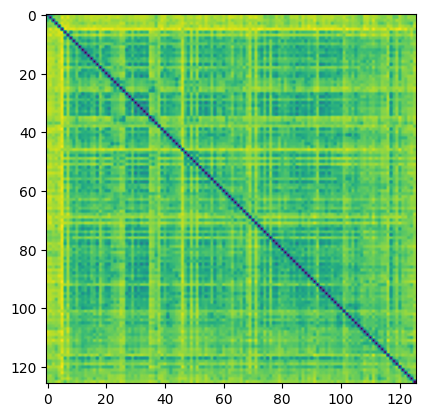

In [27]:
import matplotlib.pyplot as plt
plt.imshow(distances_matrix)

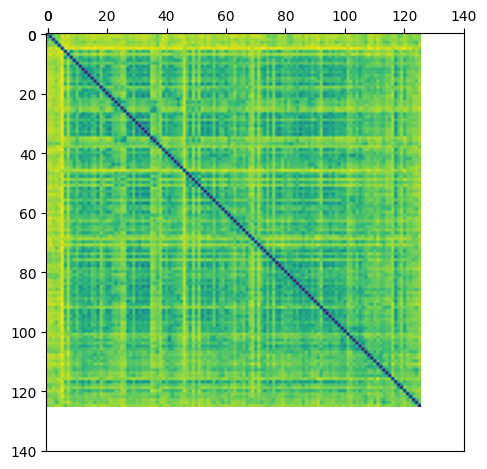

In [28]:
import matplotlib.pyplot as plt

# Assuming you've already created your distances_matrix
plt.imshow(distances_matrix)

# Get the current axes
ax = plt.gca()

# Move x-axis ticks and label to the top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Ensure the '0' tick is shown on both axes
ax.set_xticks([0] + list(ax.get_xticks()[1:]))
ax.set_yticks([0] + list(ax.get_yticks()[1:]))

# Adjust layout to prevent clipping
plt.tight_layout()

# Show the plot
plt.show()